In [1]:
!wget --no-check-certificate \
  https://raw.githubusercontent.com/ashwaniYDV/sarcasm-detection-tensorflow/main/sarcasm.json \
  -O /tmp/s2.json


--2023-05-29 20:30:09--  https://raw.githubusercontent.com/ashwaniYDV/sarcasm-detection-tensorflow/main/sarcasm.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5616834 (5.4M) [text/plain]
Saving to: ‘/tmp/s2.json’

/tmp/s2.json        100%[===================>]   5.36M  --.-KB/s    in 0.06s   

2023-05-29 20:30:10 (83.9 MB/s) - ‘/tmp/s2.json’ saved [5616834/5616834]



In [2]:
import json

with open("/tmp/s2.json", "r") as f:
  datastore = json.load(f) 

In [3]:
training_size = 20000

In [4]:

sentences = []
labels = []

for item in datastore:
  sentences.append(item["headline"])
  labels.append(item["is_sarcastic"])

In [5]:
training_sentences = sentences[:training_size]
training_labels = labels[:training_size]
test_sentences = sentences[training_size:]
test_labels = labels[training_size:]

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")

In [8]:
tokenizer.fit_on_texts(training_sentences)

In [9]:
word_index = tokenizer.word_index

In [10]:
training_seq = tokenizer.texts_to_sequences(training_sentences)
test_seq = tokenizer.texts_to_sequences(test_sentences)

In [11]:
training_padded = pad_sequences(training_seq, maxlen=100, padding="post", truncating="post")
test_padded = pad_sequences(test_seq, maxlen=100, padding="post", truncating="post")

In [12]:
import numpy as np

training_padded = np.array(training_padded)
test_padded = np.array(test_padded)
training_labels = np.array(training_labels)
test_labels = np.array(test_labels)

In [13]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=100),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(
    training_padded, 
    training_labels, 
    epochs=30, 
    validation_data = (test_padded, test_labels), 
    verbose=2)

Epoch 1/30
625/625 - 3s - loss: 0.6723 - accuracy: 0.5686 - val_loss: 0.6151 - val_accuracy: 0.6865 - 3s/epoch - 6ms/step
Epoch 2/30
625/625 - 4s - loss: 0.4596 - accuracy: 0.8198 - val_loss: 0.3944 - val_accuracy: 0.8351 - 4s/epoch - 6ms/step
Epoch 3/30
625/625 - 2s - loss: 0.3216 - accuracy: 0.8720 - val_loss: 0.3553 - val_accuracy: 0.8520 - 2s/epoch - 4ms/step
Epoch 4/30
625/625 - 2s - loss: 0.2679 - accuracy: 0.8958 - val_loss: 0.3477 - val_accuracy: 0.8527 - 2s/epoch - 4ms/step
Epoch 5/30
625/625 - 2s - loss: 0.2306 - accuracy: 0.9113 - val_loss: 0.3450 - val_accuracy: 0.8530 - 2s/epoch - 4ms/step
Epoch 6/30
625/625 - 2s - loss: 0.2025 - accuracy: 0.9240 - val_loss: 0.3487 - val_accuracy: 0.8523 - 2s/epoch - 4ms/step
Epoch 7/30
625/625 - 3s - loss: 0.1812 - accuracy: 0.9316 - val_loss: 0.3568 - val_accuracy: 0.8518 - 3s/epoch - 6ms/step
Epoch 8/30
625/625 - 2s - loss: 0.1624 - accuracy: 0.9398 - val_loss: 0.3801 - val_accuracy: 0.8484 - 2s/epoch - 4ms/step
Epoch 9/30
625/625 - 2s 

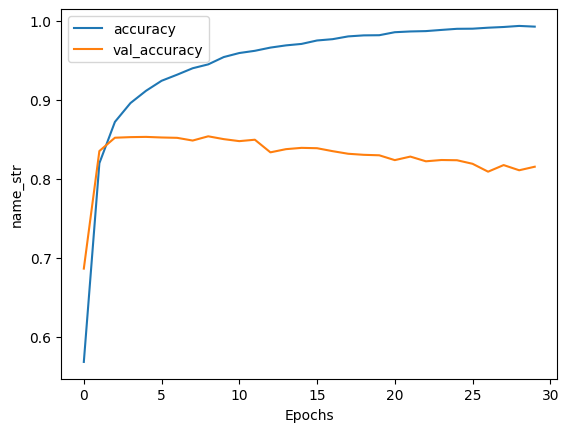

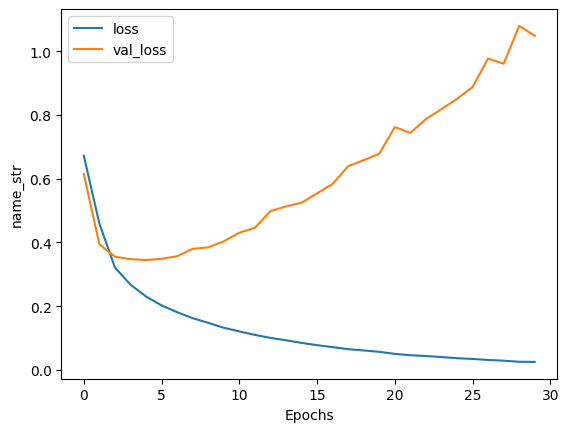

In [16]:
import matplotlib.pyplot as plt

def plot_graphs(history, name_str):
  plt.plot(history.history[name_str])
  plt.plot(history.history["val_"+name_str])
  plt.xlabel("Epochs")
  plt.ylabel("name_str")
  plt.legend([name_str, "val_"+name_str])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [17]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [18]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(10000, 16)


In [20]:
import io

vocab_size = 10000
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [21]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>